# Calculate landfast area

In [1]:
import numpy as np 
import cmocean
import cmocean.cm as cmo
import xarray as xr   
from pathlib import Path
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal, stats
import time
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import matplotlib
import warnings; warnings.simplefilter('ignore')

from functions import load_ice, trend, find_trends, plot_cartopy, decomp

# input data directory

path = Path('/extra-space1/data/tikoralukupload/cis-weekly/nc/')

# 2021
path2021 = Path('/extra-space1/data/tikoralukupload/cis-weekly/nc-for-May-2021-06-02')

# region of interest
region = 'HB'

# Projection for mapping
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

# Construct the full file name
fname = path / '{}.nc'.format(region)
fname2021 = path2021 / '{}.nc'.format(region) # 2021

### Load data into a `xarray.Dataset`:
# Note that the data is loaded lazily which means that no actual data are actually written
# into memory.
# ds = xr.open_dataset(fname, decode_times=False)
# ds2021 = xr.open_dataset(fname2021, decode_times=False)

ds = xr.open_dataset(fname)
ds2021 = xr.open_dataset(fname2021)

juld = ds.juld
juld2021 = ds2021.juld
# Combine data structures
juld = xr.concat([juld, juld2021], "juld")

# subset `xarray.Dataset` by index
# ds = ds.isel(x=slice(1700, None), y=slice(600, 1450))
# ds2021 = ds2021.isel(x=slice(1700, None), y=slice(600, 1450))

# Labrador shelf only
ds = ds.isel(x=slice(1800, 2500), y=slice(800, 1450))
ds2021 = ds2021.isel(x=slice(1800, 2500), y=slice(800, 1450))



# create shortcuts to the variables. 
lon = ds.longitude
lat = ds.latitude
land = ds.land
# E_FA = ds['E_FA']
E_CTold = ds['E_CT']
E_CT2021 = ds2021['E_CT']

E_SAold = ds['E_SA']
E_SA2021 = ds2021['E_SA']

E_CT = xr.concat([E_CTold, E_CT2021], dim="juld")
E_SA = xr.concat([E_SAold, E_SA2021], dim="juld")


## Using N_CT
N_CTold = ds['N_CT']
N_CT2021 = ds2021['N_CT']

N_CT = xr.concat([N_CTold, N_CT2021], dim="juld")


In [21]:
# Turn array into boolean where only CT=100 exists
LF = xr.where(N_CT==100., 1, 0)

# Separate data into ice years
# Loop over all years and sum up landfast ice grid cells - 10/10 CT from N_CT
cnt=0

# Extract unique years
years = juld.dt.year
years_unique = np.unique(years)

# LF area array - one value for each year
LF_area = np.zeros(len(years_unique))
# Define ice season start as sept-sept
CT_yearly = LF.resample(juld="AS-SEP")
for yr in list(CT_yearly):
    # Check if list is not empty
    if np.sum(yr[1]) >= 1:
        # Area of LF ice average over number of data days
#         LF_area[cnt] = yr[1].where(yr[1]==100).sum()/len(yr[1])
        LF_area[cnt] = yr[1].sum()/len(yr[1])
        cnt +=1            




# Calculate trend
LF_area_trend,LF_area_b = np.polyfit(years_unique,LF_area,1)


In [48]:
def plot_cartopy(ax, lon, lat, land):
    '''
    Set up the cartopy map with projection rotated so that Labrador coast is vertical. Input is the ax handle. 
    '''
    #Declare the land and ocean parameters
    LAND_highres = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
    edgecolor='dimgrey',
    facecolor=('dimgrey'),
    linewidth=1)
    OCEAN_highres = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
    facecolor='lightblue')
    # Set opacity to 0.5
    ax.background_patch.set_alpha(0.5)

    #Declare the lat and lon boundaries for the map and data
    domain = [99, 99, -99, -99]
    domain[0] = np.min(lat) # South
    domain[1] = np.min(lon) # West
    domain[2] = np.max(lat) # North
    domain[3] = np.max(lon) # East
#     domain = list(np.array(domain) + np.array([+1, +6, 0, -4]))
    domain = [54.5, -61.30979545701268, 62, -56.47452933956656]
    # domain = [55, -61.30979545701268, 59, -61]

    aoi_map = [domain[0], domain[2], domain[1], domain[3]]
#     # Plot results
#     transform = rot.transform_points(rot,lon,lat)
#     x_n = transform[...,0]
#     y_n = transform[...,1]

#     ax.add_feature(LAND_highres,zorder=1)
    ax.add_feature(OCEAN_highres,zorder=1)
    ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
    ax.fill_between([0,100000],[0,100000], color="none", hatch="..", edgecolor="k", linewidth=0.0,transform=ccrs.PlateCarree(),zorder=4)
    
    # Fill land and coastline
    plt.pcolormesh(lon,lat,land,transform=ccrs.PlateCarree(),zorder=4,cmap = matplotlib.colors.ListedColormap(['lightblue', 'lightgrey']))
    plt.contour(lon,lat,land,colors='black',transform=ccrs.PlateCarree(),zorder=4)

#     ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)
    

<IPython.core.display.Javascript object>


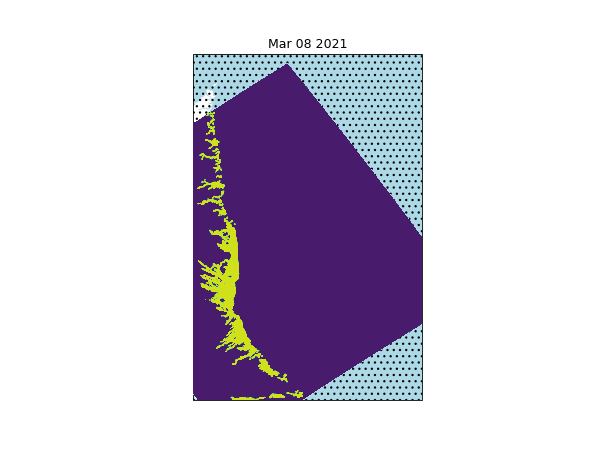

Text(0.5, 1.0, 'Mar 08 2021')

In [66]:
%matplotlib notebook
dd=-12
fig = plt.figure(figsize=(8,6), facecolor='white')
ax = fig.add_subplot(111, projection=rot)
plot_cartopy(ax,lon,lat,land)
plt.contourf(lon,lat,LF[dd],transform=ccrs.PlateCarree(),zorder=4)
plt.title(juld.dt.strftime("%b %d %Y").values[dd])
# plt.colorbar()

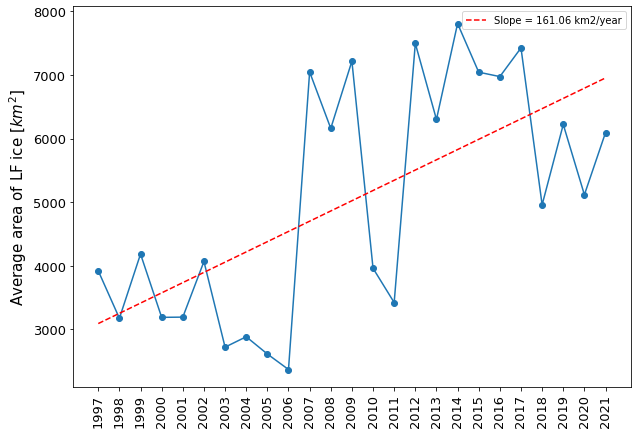

In [30]:
# Plot LF area mean

fig = plt.figure(figsize=(10,7), facecolor='white')

plt.plot(years_unique, LF_area, 'o-')
plt.xticks(years_unique,rotation='vertical', fontsize=13)
plt.plot(years_unique, LF_area_trend*years_unique + LF_area_b, 'r--', label='Slope = %.2f km2/year' %LF_area_trend)
plt.yticks(fontsize=13)
plt.ylabel(r'Average area of LF ice [$km^2$]', fontsize=15)
# plt.savefig('/home/mwang/CIS/figures/Aug24_area_mean_sep.png', dpi=200)
plt.legend()